# **거래까지 걸린 시간 찾기**

In [157]:
import pandas as pd 
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score,KFold
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

plt.rc('font',family = 'malgun gothic')

In [45]:
df = pd.read_csv("C:/Users/whileduck/Desktop/Github/Concert-Hall-Price-Model/data/오픈여부_추가_클래식_데이터.csv", low_memory = False)

display(df.head())
print(df.shape)

,seat,층,블록,열,넘버,X,Y,Z,대칭점,좌우시야각,...,intermission,member_yn,공연연도,공연월,공연일,공연연월,전체공연시간,전체거래시간,누적검색량,좌석 오픈 여부
0,1층 A블록1열 1,1층,A블록,1,1,1451,542,-93,1층 E블록1열 9,15,...,15,N,2018,11,2018-11-25,2018-11-01,2018-11-25 17:00:00,2018-11-16 15:06:00,1000,1
1,1층 A블록1열 2,1층,A블록,1,2,1406,555,-93,1층 E블록1열 8,16,...,15,N,2018,11,2018-11-25,2018-11-01,2018-11-25 17:00:00,2018-11-16 15:06:00,1000,1
2,1층 A블록1열 3,1층,A블록,1,3,1361,568,-93,1층 E블록1열 7,18,...,15,N,2018,11,2018-11-25,2018-11-01,2018-11-25 17:00:00,2018-11-16 15:06:00,1000,1
3,1층 A블록1열 4,1층,A블록,1,4,1315,580,-93,1층 E블록1열 6,21,...,15,N,2018,11,2018-11-25,2018-11-01,2018-11-25 17:00:00,2018-11-16 15:06:00,1000,1
4,1층 A블록1열 5,1층,A블록,1,5,1270,591,-93,1층 E블록1열 5,23,...,15,N,2018,11,2018-11-25,2018-11-01,2018-11-25 17:00:00,2018-11-16 15:06:00,1000,1


(405810, 42)


# **예매된 경우 거래까지 걸린 시간 찾기**

In [46]:
def convert_string_to_hours(time_string):

    parts = time_string.split()
    time_parts = parts[2].split(':')
    
    days = int(parts[0])
    hour = int(time_parts[0])
    minutes = int(time_parts[1])

    return (days * 24) + hour + (minutes / 60)

def transaction_time(data):
    
    
    data = data.copy()
    data['거래까지걸린시간'] = np.NaN # default 값은 NaN 값을 맵핑하기 
    data['거래까지걸린시간_시간'] = np.NaN # default 값은 NaN 값을 맵핑하기 
    
    
    # 조건 찾기 
    purchase_cond = data['예매여부'] == 1 # 예매 된 경우에 대한 조건 
    open_cond = data['pre_open_date'].isna() # 선 예매가 되지 않은 경우에 대한 조건 
    
    # 조건에 따라 다르게 맵핑하기 
    
    open_time = pd.to_datetime(data.loc[(purchase_cond) & (open_cond), 'open_date'])
    open_purchase_time = pd.to_datetime(data.loc[(purchase_cond) & (open_cond), '전체거래시간'])
    
    pre_open_time = pd.to_datetime(data.loc[(purchase_cond) & (~open_cond), 'pre_open_date'])
    pre_open_purchase_time = pd.to_datetime(data.loc[(purchase_cond) & (~open_cond), '전체거래시간'])
    
    data.loc[(purchase_cond) & (open_cond),'거래까지걸린시간'] = open_purchase_time - open_time
    data.loc[(purchase_cond) & (~open_cond),'거래까지걸린시간'] = pre_open_purchase_time - pre_open_time
    
    data.loc[purchase_cond, '거래까지걸린시간_시간'] = data.loc[purchase_cond,'거래까지걸린시간'].map(lambda x: convert_string_to_hours(str(x)))
    
    return data
    
    

In [47]:
result = transaction_time(df)

In [48]:
cond = result['예매여부'] == 1
print('예매여부가 1인 경우')
display(result.loc[cond,['seat','open_date','pre_open_date','전체거래시간','거래까지걸린시간']].sample(3))
print('예매여부가 0인 경우')
display(result.loc[~cond,['seat','open_date','pre_open_date','전체거래시간','거래까지걸린시간']].sample(3))

예매여부가 1인 경우


,seat,open_date,pre_open_date,전체거래시간,거래까지걸린시간
311682,1층 E블록19열 5,2022-09-09,NaN,2022-10-01 15:12:00,22 days 15:12:00
205471,1층 A블록7열 5,2021-09-20,2021-09-19,2021-10-12 07:59:00,23 days 07:59:00
668,1층 B블록13열 2,2018-10-29,2018-10-28,2018-11-01 10:16:00,4 days 10:16:00


예매여부가 0인 경우


,seat,open_date,pre_open_date,전체거래시간,거래까지걸린시간
216974,2층 C블록4열 11,2021-09-06,2021-09-04,NaN,NaN
314501,합창석 F블록3열 12,2022-09-17,2022-09-16,NaN,NaN
160867,1층 C블록7열 5,2020-08-24,2020-08-23,NaN,NaN


# **거래까지 걸린 시간을 구했으면 공연 별로 구매가 된 순서대로 맵핑해보자**

- 독립적인 공연 별로 구매가 가장 빨리 이뤄진 순서대로 오름차순으로 번호를 맵핑하고, 예매가 되지 않은 경우는 모두 2050 번째 좌석으로 맵핑해보자 
    
    - 만약 좌석이 오픈되지 않은 경우에는 어떻게 할까 ? 
    - 일단은 모두 오픈 여부와 상관없이 예매가 안된 경우는 최대 등수인 오픈된 좌석 수로 맵핑하도록 해보자



- 다만 고려해야 할 경우가 있다. 코로나 기간 때에는 좌석이 오픈되지 않은 경우들이 있기 때문에 좌석이 오픈되지 않은 경우에 대해서는 (옆 좌석에 이미 예매가 있을 경우 오픈이 되지 않았다.) 예매된 좌석과 유사한 등수를 가졌을 것이라 생각하고, 예매가 된 좌석들 중 k 개의 좌석의 등수로 평균화하여 생각하자

In [49]:
# def during_transcation(data):
    
#     covid_cond = (data['전체공연시간'] <= '2022-06-09 19:30:00') & (data['전체공연시간'] >= '2020-05-05 20:00:00') # 거리두기 기간
    
    
#     # 거리두기 기간이 아닌 경우의 등수 
    
#     not_covid_data = data[~covid_cond].copy()
    
#     not_covid_unique_performance = sorted(not_covid_data['전체공연시간'].unique())
    
#     not_covid_data['거래까지걸린시간_등수'] = np.NaN # default 값을 결측치로 설정, 거래가 이뤄지지 않은 좌석은 결측치로 남도록
        
#     for uniq_perf in not_covid_unique_performance:
        
#         cond = not_covid_data['전체공연시간'] == uniq_perf
        
#         transaction_rank = sorted(not_covid_data.loc[cond,'거래까지걸린시간_시간'].unique())
        
#         transaction_dict = {var : i  for i,var in enumerate(transaction_rank)} 
        
#         not_covid_data.loc[cond,'거래까지걸린시간_등수'] = not_covid_data.loc[cond,'거래까지걸린시간_시간'].map(transaction_dict) # 거래까지 걸린 시간이 빠를 수록 1에 가깝게 맵핑
        
#         max_rank = np.max(not_covid_data.loc[cond,'거래까지걸린시간_등수'])
        
#         not_covid_data.loc[not_covid_data['거래까지걸린시간_시간'].isna(), '거래까지걸린시간_등수'] = max_rank + 1 # 거래가 되지 않은 경우는 최대 등수 + 1 로 맵핑  
                
                
#     covid_data = data[covid_cond].copy() # 코로나 기간일 떄의 등수 측정하기 
    
#     covid_unique_performance = sorted(covid_data['전체공연시간'].unique())
    
#     covid_data['거래까지걸린시간_등수'] = np.NaN
    
    
#     best_k_list = []
#     k_mean_score = []
#     k_mean_std = []
#     open_num_list = []
#     print('예매되지 않은 좌석의 등수 추정 중')
    
#     for uniq_perf in tqdm(covid_unique_performance):
        
#         perf_cond = covid_data['전체공연시간'] == uniq_perf  # 공연 시간에 대한 컨디션 
#         open_cond = covid_data['좌석 오픈 여부'] == 1 # 좌석이 오픈 된 것에 대한 컨디션
        
        
#         train_transaction_rank = sorted(covid_data.loc[(perf_cond) & (open_cond),'거래까지걸린시간_시간'].unique())
#         train_transaction_dict = {var : i + 1 for i,var in enumerate(train_transaction_rank)} 
        
#         covid_data.loc[perf_cond, '거래까지걸린시간_등수'] = covid_data.loc[perf_cond, '거래까지걸린시간_시간'].map(train_transaction_dict)

#         # train = covid_data.loc[(perf_cond) & (open_cond)] # 좌석이 오픈된 경우는 등수를 계산 할 수 있으며 학습에 사용 될 데이터 
#         # test = covid_data.loc[(perf_cond) & ~(open_cond)] # 좌석이 오픈되지 않은 경우는 등수를 추정해야 할 데이터
        
        
#         purchase_cond = data['예매여부'] == 1
        
#         # covid 일 때는 전체 코비드 기간이 아닐 때 구매가 된 좌석의 랭킹 데이터를 가져와 학습 하도록 하자 
#         train = not_covid_data.loc[purchase_cond , ['X','Y','Z']]
        
#         # 좌석의 좌표와 등수만을 가지고 비오픈 지역을 추정하자 
        
#         x_train,y_train = train[['X','Y','Z']] , train['거래까지걸린시간_등수'] 
#         x_test,y_test = test[['X','Y','Z']] , test['거래까지걸린시간_등수']
        
#         avg_scores_list = []
#         std_list = []
        
#         for k in range(2,9 + 1): # 최적의 k 개를 찾자 
            
#             model = KNeighborsRegressor(n_neighbors = k, weights  = 'distance')
#             scores = cross_val_score(model, x_train,y_train, cv = 30, scoring = 'neg_mean_squared_error')
#             avg_scores_list.append(np.squeeze(np.mean(scores)))
#             std_list.append(np.squeeze(np.std(scores)))
            
#         best_k = np.argmin(avg_scores_list) + 2 # 최적의 k 개는 avg_scores_list 의 가장 낮을 수록 좋은 k 개 
        
#         best_k_list.append(best_k)
#         k_mean_score.append(np.abs(avg_scores_list[best_k - 2]))
#         k_mean_std.append(std_list[best_k - 2])
#         open_num_list.append(np.sum(covid_data.loc[perf_cond,'좌석 오픈 여부']))
#         # best_k 를 추정했으면 학습해서 채워두자 
        
#         best_model = KNeighborsRegressor(n_neighbors = best_k, weights = 'distance')
#         best_model.fit(x_train,y_train)
#         y_predict = best_model.predict(x_test).reshape(1,-1)
#         y_predict += np.random.random(size = (1,len(y_predict))) # 예측값들의 등수가 동일하게 나오는 경우를 방지하기 위해 난수를 추가
        
        
#         covid_data.loc[(perf_cond) & (~open_cond), '거래까지걸린시간_등수'] = np.squeeze(y_predict) # 해당 날짜와 추정된 조건의 거래까지 걸린 시간의 등수를 예측값으로 추정해두자 

#         covid_data.loc[(perf_cond) & (open_cond) & (covid_data.loc[(perf_cond) & (open_cond),'거래까지걸린시간_시간'].isna()),'거래까지걸린시간_등수'] = np.sum(covid_data.loc[perf_cond, '좌석 오픈 여부']) # 최대 좌석 오픈 개수로 맵핑
        
                                                                                        
#     knn_table = pd.DataFrame(
#         {'전체공연시간': covid_unique_performance,
#         'best_k' : best_k_list,
#         'mse_score' : k_mean_score,
#         'std' : k_mean_std,
#         '좌석오픈개수' : open_num_list}
#     )
    
#     total_data = pd.concat([not_covid_data, covid_data])
    
#     return total_data, knn_table

In [209]:
def rank_mapping(data):
    
    '''
    거리두기 기간 전과 후의 예매된 좌석들의 예매까지 걸린 등수를 정하고 
    이 때 예매가 되지 않은 좌석은 해당 공연에서 가장 마지막 등수 + 1로 맵핑하도록 함 

    예매까지 걸린 등수를 0과 1 사이의 값으로 표준화 하여 등수 점수라는 지표로 생성 
    등수 점수는 1 - {(현재 등수 + 1) / 최대 등수 } 로 표현하여 가장 빨리 예매된 경우 1, 예매가 늦게 된 순으로 0에 가까운 값이 되도록 생성    
    
    거리두기 기간 전의 등수를 먼저 구한 후 거리두기 기간 동안 오픈되지 않은 좌석은 예매 되었을 때의 예상 등수 점수를 예측하여 채워주도록 함 
    '''
    unique_performance = sorted(data['전체공연시간'].unique())
    
    result_list = []
    
    for uniq_perform in unique_performance:
        
        perform_cond = data['전체공연시간'] == uniq_perform
        
        cond_df = data[perform_cond].copy()
        
        na_cond = cond_df['거래까지걸린시간_시간'].isna()
        
        time_list = sorted(cond_df.loc[~na_cond,'거래까지걸린시간_시간'].unique()) # 거래까지 걸린 시간을 오름차순으로 정렬
        
        rank_dict = {var : i + 1 for i,var in enumerate(time_list)}
        
        
        cond_df['거래까지걸린시간_등수'] =  cond_df['거래까지걸린시간_시간'].map(rank_dict)  # 걸린 시간을 등수로 등수화 
                                                    # 이 때 예매가 되지 않은 경우는 여전히 np.NaN 값으로 남아있음 

        max_rank = np.max(cond_df['거래까지걸린시간_등수']) # 예매가 되지 않은 좌석에 추가가 될 데이터 
        
        cond_df['거래까지걸린시간_등수'] = cond_df['거래까지걸린시간_등수'].fillna(max_rank + 1 ) # 예매가 되지 않은 좌석은 최고 순위 + 1 로 맵핑 하도록 함 
        
        # 등수 점수를 구하자 
        
        cond_df['표준화 등수 점수'] = 1 - ((cond_df['거래까지걸린시간_등수'] - 1) / max_rank) # 가장 빨리 예매 되었을 경우 1에 가깝게, 예매가 늦게 되었을 경우 0에 가깝게 
                                                                                            # 예매가 되지 않은 경우는 0에 수렴 
        result_list.append(cond_df) # 완성된 데이터프레임은 not_covide_result_list 에 담아주자
        
    result = pd.concat(result_list) # 완성된 데이터
    
    return result 

In [246]:
def covid_knn_modeling(data):
    '''
    거리두기 기간 동안 거리두기로 인해 오픈되지 않은 경우에도 
    
    예매되지 않은 좌석들과 같은 등급으로 맵핑하는 것보다, KNN 을 이용해 적합한 등수를 추정하는 것이 좋을 것이라고 생각했다. 
    
    좋은 좌석임에도 불구하고 거리두기로 인해 옆 좌석으로 인해 오픈되지 않은 경우의 특수성을 고려해야 할 필요가 있다고 생각한다.
    
    '''
    
    covid_cond = (data['전체공연시간'] >= '2020-05-05 20:00:00') & (data['전체공연시간'] <= '2022-06-09 19:30:00') # 거리두기 기간
    
    # 거리두기 기간과 거리두기 기간 전,후의 데이터로 나눠줌 
    covid_data = data[covid_cond]
    not_covid_data = data[~covid_cond]
    
    # 거리두기 기간이 아닌 경우는 무리없이 등수와 표준화된 등수를 완성할 수 있다
    
    not_covid_result = rank_mapping(not_covid_data)
    
    # 거리두기 기간 동안 예매되지 않은 좌석에 대해서는 등수를 KNN 을 통해서 지정해주도록 하자 
    # 우선 예매여부가 0이면서 오픈 되지 않은 좌석은 위와 같이 최대 등수 + 1 로 해서 맵핑하도록 하고 
    # 거리두기로 인해 예매여부가 0인 좌석들에 대해서는 예매된 좌석들 등수로 KNN 을 통해 해주고, 결국은 예매 된 좌석보다는 늦게 구매가 된 것이니 
    # KNN 으로 추정된 등수 + 0과 n 사이의 양수값을 추가해주도록 하자 
    
    unique_performance = sorted(covid_data['전체공연시간'].unique())
    
    best_k_list = []
    best_avg_knn_list = []
    best_avg_max_list = []
    avg_max_rank_avg_list = []
    open_num_list = []
    result_list = []
    
    for uniq_perf in tqdm(unique_performance):
        
        perf_cond = covid_data['전체공연시간'] == uniq_perf
        
        cond_df = covid_data[perf_cond].copy()
        
        not_open_cond = cond_df['좌석 오픈 여부'] == 0 # 거리두기로 인해 좌석이 오픈되지 않은 경우의 컨디션 
        
        na_cond = cond_df['거래까지걸린시간_시간'].isna()
        
        
        #  rank_mapping 과 같은 형식
        time_list = sorted(cond_df.loc[~na_cond, '거래까지걸린시간_시간'].unique())
        
        rank_dict = {var : i + 1 for i,var in enumerate(time_list)}
        
        cond_df['거래까지걸린시간_등수'] =  cond_df['거래까지걸린시간_시간'].map(rank_dict)
        max_rank = np.max(cond_df['거래까지걸린시간_등수'])
        cond_df.loc[(~ not_open_cond) & (na_cond), '거래까지걸린시간_등수'] = max_rank + 1 
        
        
        #  rank_mapping 과 같은 형식
        
        
        # 좌석이 오픈 되지 않은 경우에는 KNN 모델을 이용해서 계산해보자
        
        # 오픈이 된 경우는 train , 오픈이 되지 않은 경우는 test 로 두도록 함 
        
        train = cond_df.loc[(~not_open_cond) & (~na_cond) ,['X','Y','Z','거래까지걸린시간_등수']]
        test = cond_df.loc[not_open_cond, ['X','Y','Z','거래까지걸린시간_등수']]
        
        x_train,y_train = train.drop('거래까지걸린시간_등수', axis = 1), train['거래까지걸린시간_등수']
        x_test,y_test = test.drop('거래까지걸린시간_등수', axis = 1), test['거래까지걸린시간_등수']
        
        
        k_list = list(range(2,5 + 1)) # 이웃해서 볼 k 개의 개수는 2 에서 5까지만 보도록 하자 
        
        knn_avg_score_list = []
        max_rank_avg_score_list = []
        max_rank_avg_list = []
        for k in k_list:
            
            model = KNeighborsRegressor(n_neighbors = k , weights = 'distance') # weight 는 가까울 수록 크게 주자 
            
            
            
            splits = 10
            cv = KFold(n_splits = splits)
            
            knn_score_list = []
            max_rank_score_list = []
            max_rank_list = []
            
            for train_idx , test_idx in cv.split(x_train,y_train):
                
                train_x,train_y = x_train.iloc[train_idx],y_train.iloc[train_idx]
                valid_x,valid_y = x_train.iloc[test_idx], y_train.iloc[test_idx]
                
                max_rank = np.max(train_y)
                
                model.fit(train_x,train_y)
                y_pred = model.predict(valid_x)
                
                knn_score_list.append(mean_absolute_error(valid_y, y_pred))
                max_rank_score_list.append(mean_absolute_error(valid_y, [max_rank + 1] * len(valid_y)))
                max_rank_list.append(max_rank)
                
            knn_avg_score_list.append(np.mean(knn_score_list))
            max_rank_avg_score_list.append(np.mean(max_rank_score_list))
            max_rank_avg_list.append(np.mean(max_rank_list))
        best_idx = np.argmin(knn_avg_score_list)
        best_k =  best_idx + 2 # neg mean squared_error 가 가장 낮은 값이 best k
        
        best_k_list.append(best_k)
        best_avg_knn_list.append(knn_avg_score_list[best_idx])
        best_avg_max_list.append(np.mean(max_rank_avg_score_list))
        avg_max_rank_avg_list.append(np.mean(max_rank_avg_list))
        open_num_list.append(np.sum(~ not_open_cond))
        
        final_model = KNeighborsRegressor(n_neighbors = best_k, weights = 'distance')
        final_model.fit(x_train,y_train)
        
        y_predict = final_model.predict(x_test) # 좌석이 오픈되지 않은 경우의 등수를 예측하는 모델 
        
        cond_df.loc[not_open_cond, '거래까지걸린시간_등수'] = y_predict
        
        # 좌석이 오픈 되면서 예매되지 않은 경우는 max_rank + 1 로 맵핑 하자
        


        # covid_result 도 표준화된 등수 점수를 사용하도록 하자 
        cond_df['표준화 등수 점수'] = 1 - ((cond_df['거래까지걸린시간_등수'] - 1) / max_rank)
    
        result_list.append(cond_df)
    
    covid_result = pd.concat(result_list)
    # 합쳐서 total result 생성 
    total_result = pd.concat([not_covid_result,covid_result])    
    # covid 기간 동안의 KNN 모델의 MSE 를 요약하는 테이블 생성 


    knn_table = pd.DataFrame(
        {'날짜': unique_performance,
        'BEST_K' : best_k_list,
        'AVG_MAE [KNN]': best_avg_knn_list,
        'AVG_MAE [MAX]' : best_avg_max_list,
        '평균최대등수': avg_max_rank_avg_list,
        '오픈좌석수':open_num_list}
    )
    
    
    return total_result,knn_table

In [247]:
total_result , knn_table = covid_knn_modeling(result)

100%|██████████| 49/49 [00:05<00:00,  9.00it/s]


Text(0.5, 1.0, '빈 좌석을 MAX 값으로 추정하기 vs 빈 좌석을 KNN 값으로 추정하기')

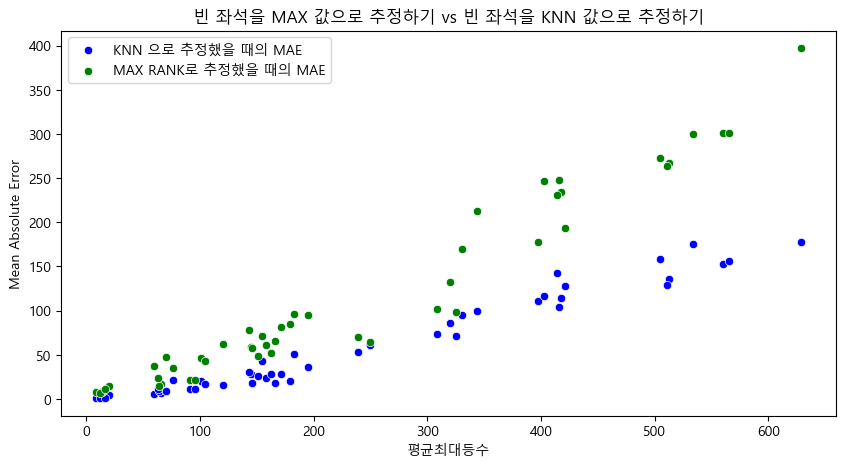

In [248]:
fig,ax = plt.subplots(figsize = (10,5))

sns.scatterplot(
    data = knn_table,
    x = '평균최대등수',
    y = 'AVG_MAE [KNN]',
    c = 'b',
    label = 'KNN 으로 추정했을 때의 MAE',
    ax = ax   
)

sns.scatterplot(
    data = knn_table,
    x = '평균최대등수',
    y = 'AVG_MAE [MAX]',
    c = 'g',
    label = 'MAX RANK로 추정했을 때의 MAE',
    ax = ax   
)

ax.set_ylabel('Mean Absolute Error')
ax.set_title('빈 좌석을 MAX 값으로 추정하기 vs 빈 좌석을 KNN 값으로 추정하기')

# **거리두기 기간 KNN 산점도의 결과를 보면 다음과 같다**

 1. 각 공연 별 오픈되지 않은 좌석의 등수를 추정하기 위한 최적의 이웃 개수는 모두 2개로 동일하다. 

 2. 2/3 이상의 공연에서 KNN 대치는 30번의 교차검증에서 평균적으로 MSE 5000 이하로 준수하였으나, 1/3 이상의 공연에서는 평균 이상의 높은 MSE 를 보이며 성능이 준수하지 못함을 나타내고 있다. 

 3. 이는 오픈된 좌석의 개수와 관계 없이 공연의 특수한 성질에 의해 발생한 문제로 시사되며 추후 추가적 보정이 필요할 것으로 보인다.

In [250]:
# 예시의 경우를 통해 잘 되었는지 살펴보자 
# 코로나가 아닌 경우

total_result[total_result['전체공연시간'] == '2022-12-04 17:00:00'][['예매여부','거래까지걸린시간_시간','거래까지걸린시간_등수']].sort_values(by = '거래까지걸린시간_등수').drop_duplicates() 

,예매여부,거래까지걸린시간_시간,거래까지걸린시간_등수
347896,1,14.016667,1.0
345818,1,14.033333,2.0
347897,1,14.116667,3.0
346080,1,14.133333,4.0
345716,1,14.166667,5.0
...,...,...,...
346115,1,2152.833333,328.0
346788,1,2152.866667,329.0
346651,1,2152.983333,330.0
346090,1,2153.100000,331.0


In [251]:
# 거리두기 기간인 경우

total_result[total_result['전체공연시간'] == '2020-06-03 19:30:00'][['예매여부','좌석 오픈 여부','거래까지걸린시간_시간','거래까지걸린시간_등수']].sort_values(by = '거래까지걸린시간_등수').drop_duplicates() 

,예매여부,좌석 오픈 여부,거래까지걸린시간_시간,거래까지걸린시간_등수
146468,1,1,326.033333,1.0
146973,1,1,333.533333,2.0
147277,1,1,343.683333,3.0
146725,1,1,352.283333,4.0
147165,1,1,372.633333,5.0
...,...,...,...,...
145755,1,1,4556.566667,142.0
146904,1,1,4556.600000,143.0
146831,1,1,4556.666667,144.0
146833,1,1,4557.083333,145.0


##### **잘 계산된 것으로 보인다 저장해주자**

In [12]:
file_path = 'C:/Users/whileduck/Desktop/빈좌석/'

result.to_csv(file_path + '클래식_빈좌석포함데이터.csv',index = False)  